<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/07-cv-flower-recognition/cv_flower_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Imports
Load all necessary libraries and set random seeds for reproducibility.

In [1]:
import os
import requests
import tarfile
import io
import json
import multiprocessing

import pandas as pd
import numpy as np
import random
from collections import Counter

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

import timm

import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

from PIL import Image, UnidentifiedImageError

In [2]:
# Set random seed for reproducibility of results
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
BATCH_SIZE = 32
EPOCHS = 40

In [4]:
# Choose device: GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using this device: {device}')

Using this device: cuda


# Dataset Preparation
Download the dataset, check for corrupted images, and prepare utilities for handling the data.


In [5]:
# Download and unzip the dataset from the given URL
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/progetto-finale-flowes.tar.gz'
data_path = "/content/progetto-finale-flowes"

if not os.path.exists(data_path):
  response = requests.get(url)
  response.raise_for_status()

  with tarfile.open(fileobj=io.BytesIO(response.content), mode='r:gz') as tar:
      tar.extractall(path="/content/")
else:
  print("Dataset already exists.")

Dataset already exists.


In [6]:
# Check if image is valid
def is_valid_image(file_path):
  try:
    with Image.open(file_path) as img:
      img.verify()
    return True
  except (IOError, UnidentifiedImageError):
      return False

In [7]:
def get_class_num(images_dir):
  class_num = 0
  for class_name in os.listdir(images_dir):
    class_folder = os.path.join(images_dir, class_name)
    if os.path.isdir(class_folder):
      class_num +=1
  return class_num

In [8]:
def filter_invalid_images(images_dir):
  valid_file = []
  for class_name in os.listdir(images_dir):
    class_folder = os.path.join(images_dir, class_name)
    if os.path.isdir(class_folder):
      for file_name in os.listdir(class_folder):
        if not file_name.startswith('._'):
          file_path = os.path.join(class_folder, file_name)
          if is_valid_image(file_path):
            valid_file.append(file_path)
  return valid_file

In [9]:
class FlowerDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        self.class_map = {'daisy':0, 'dandelion':1}
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        label_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_map[label_name]
        # Apply Albumentations transform
        if self.transform:
            image = np.array(image)
            image = self.transform(image=image)["image"]
        return image, label

# Model Setup
Load EfficientNet-B0 from timm, configure input normalization, and define freeze/unfreeze functions.


In [10]:
pd.DataFrame(timm.list_models('tf_efficientnet_b0*', pretrained=True))

,0
0,tf_efficientnet_b0.aa_in1k
1,tf_efficientnet_b0.ap_in1k
2,tf_efficientnet_b0.in1k
3,tf_efficientnet_b0.ns_jft_in1k


In [11]:
class_num = get_class_num('/content/progetto-finale-flowes/train')
model = timm.create_model('tf_efficientnet_b0.aa_in1k', pretrained=True, num_classes=class_num)

# Set the device and data type for the model
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
model_cfg = model.default_cfg

# Show the default configuration values
df = pd.DataFrame.from_dict(model_cfg, orient='index')
print(df)

                                                                  0
url               https://github.com/rwightman/pytorch-image-mod...
hf_hub_id                           timm/tf_efficientnet_b0.aa_in1k
architecture                                     tf_efficientnet_b0
tag                                                         aa_in1k
custom_load                                                   False
input_size                                            (3, 224, 224)
fixed_input_size                                              False
interpolation                                               bicubic
crop_pct                                                      0.875
crop_mode                                                    center
mean                                          (0.485, 0.456, 0.406)
std                                           (0.229, 0.224, 0.225)
num_classes                                                    1000
pool_size                                       

In [13]:
IMAGENET_MEAN, IMAGENET_STD = model_cfg["mean"], model_cfg["std"]

# Freeze → unfreeze of EfficientNet-B0

In [14]:
# Freeze backbone (feature extractor)
def freeze_backbone(model):
    for name, param in model.named_parameters():
        # freeze all but classifier
        if "classifier" not in name:
            param.requires_grad = False

# Unfreeze backbone (fine-tuning)
def unfreeze_backbone(model):
    for param in model.parameters():
        param.requires_grad = True

# Data Augmentation and DataLoaders
Define raw and augmented transformations using Albumentations, and create DataLoaders.


In [15]:
raw_transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Affine(translate_percent=0.1, scale=(0.8, 1.2), rotate=(-25, 25), p=0.5),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

test_transform = val_transform

In [16]:
# Create list of valid files for each split
train_valid_files = filter_invalid_images('/content/progetto-finale-flowes/train')
val_valid_files   = filter_invalid_images('/content/progetto-finale-flowes/valid')
test_valid_files  = filter_invalid_images('/content/progetto-finale-flowes/test')

# Create a FlowerDataset instance for each split just with resize
train_dataset_raw = FlowerDataset(train_valid_files, transform=raw_transform)
val_dataset_raw   = FlowerDataset(val_valid_files,   transform=raw_transform)
test_dataset_raw  = FlowerDataset(test_valid_files,  transform=raw_transform)

# Create a FlowerDataset instance with augmented imgs
train_dataset = FlowerDataset(train_valid_files, transform=train_transform)
val_dataset   = FlowerDataset(val_valid_files,   transform=val_transform)
test_dataset  = FlowerDataset(test_valid_files,  transform=test_transform)

In [17]:
num_workers = multiprocessing.cpu_count()#//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': BATCH_SIZE,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': device.type == 'cuda',  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': str(device) if device.type == 'cuda' else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
}

# Create DataLoader(s)
train_loader = DataLoader(train_dataset, **data_loader_params, shuffle=True)
val_loader = DataLoader(val_dataset, **data_loader_params, shuffle=False)
test_loader = DataLoader(test_dataset, **data_loader_params, shuffle=False)

In [18]:
# Print the number of batches in the training and validation DataLoaders
print(f'Number of batches in train DataLoader: {len(train_loader)}')
print(f'Number of batches in validation DataLoader: {len(val_loader)}')

Number of batches in train DataLoader: 40
Number of batches in validation DataLoader: 12


# Exploratory Data Analysis
Check dataset structure, visualize samples, and inspect class distribution.


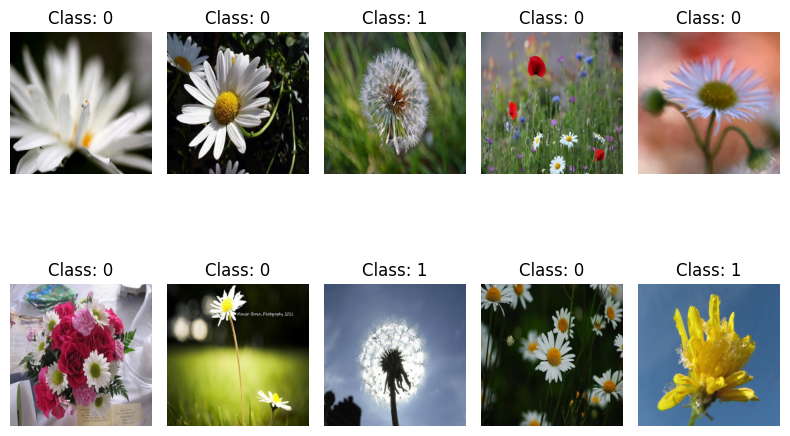

In [19]:
indices = random.sample(range(len(train_dataset)), 10)

plt.figure(figsize = (8,6))
for i, index in enumerate(indices):
  image, label = train_dataset_raw[index]
  # if img is tensor
  if isinstance(image, torch.Tensor):
    img_np = image.permute(1,2,0).numpy()
  else:
    img_np = np.array(image)
  plt.subplot(2,5,i+1)
  plt.imshow(img_np)
  plt.title(f"Class: {label}")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# Print dataset statistics
print(f'Train samples: {len(train_dataset)}')
print(f'Valid samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Train samples: 1275
Valid samples: 364
Test samples: 182


In [21]:
def plot_class(ax, img_dataset, title):
    idx_to_class = {0: 'daisy', 1: 'dandelion'}
    all_labels = []
    for index in range(len(img_dataset)):
        _, label = img_dataset[index]
        all_labels.append(label)

    labels_count = Counter(all_labels)
    labels = [0, 1]
    counts = [labels_count.get(idx, 0) for idx in labels]
    class_names = [idx_to_class[idx] for idx in labels]

    bars = ax.bar(class_names, counts, color='orange')
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('# of Images', fontsize=12)
    ax.set_title(title, fontsize=14)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 2, int(yval),
                ha='center', va='bottom', fontsize=11)

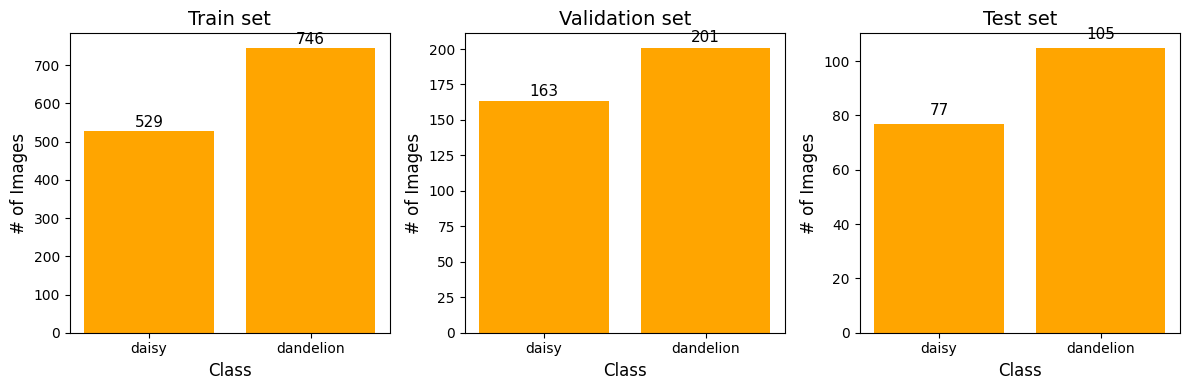

In [22]:
# Create a row of 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_class(axes[0], train_dataset_raw, "Train set")
plot_class(axes[1], val_dataset_raw, "Validation set")
plot_class(axes[2], test_dataset_raw, "Test set")
plt.tight_layout()
plt.show()

# Training Utilities
Define early stopping, training and evaluation functions, and the main fit loop.


In [23]:
# Early stopping utility to avoid overfitting (stop if no val improvement for X epochs)
class EarlyStopping:
    def __init__(self, patience=5, checkpoint_path="checkpoint.pt") -> None:
        self.patience = patience
        self.counter = 0
        self.best_f1 = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path

    def __call__(self, f1_score: float, model=None, optimizer=None, epoch=None) -> None:
        if self.best_f1 is None or f1_score > self.best_f1:
            self.best_f1 = f1_score
            self.counter = 0
            if model is not None:  # Save only if model provided
                self._save_checkpoint(model, optimizer, epoch)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def _save_checkpoint(self, model, optimizer, epoch):
        state = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer is not None else None,
            'epoch': epoch,
            'best_score': self.best_f1
        }
        torch.save(state, self.checkpoint_path)

In [24]:
def evaluate(model, dataloader, criterion=None, return_preds=False):
    """
    Evaluate a PyTorch model on a dataset (validation or test).

    Parameters
    ----------
    model : torch.nn.Module
        Model to evaluate.
    dataloader : torch.utils.data.DataLoader
        DataLoader for the dataset.
    criterion : torch.nn.Module, optional
        Loss function. If None, loss will not be computed.
    return_preds : bool, default=False
        If True, returns also y_true and y_pred.

    Returns
    -------
    metrics : dict
        Dictionary with 'loss', 'accuracy', 'f1_macro'.
    (optionally) y_true, y_pred : list of int
        Ground truth and predicted labels, only if return_preds=True.
    """
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if criterion is not None:
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)  # weighted sum

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute metrics
    avg_loss = val_loss / total if criterion is not None else None
    accuracy = correct / total
    f1 = f1_score(y_true, y_pred, average='macro')

    metrics = {
        "loss": avg_loss,
        "accuracy": accuracy,
        "f1_macro": f1
    }

    if return_preds:
        return metrics, y_true, y_pred
    else:
        return metrics

In [25]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler=None):
    """
    Train the model for one epoch.
    """
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = train_loss / total
    accuracy = correct / total

    return {"loss": avg_loss, "accuracy": accuracy}

In [26]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, early_stopping=None):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "val_f1": []}

    for epoch in range(epochs):
        # After 5 epochs, unfreeze backbone and redefine optimizer/scheduler
        if epoch == 5:
            print("Unfreezing backbone for fine-tuning")
            unfreeze_backbone(model)
            optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - epoch)

        # training
        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, scheduler)

        # validation
        val_metrics = evaluate(model, val_loader, criterion)

        if scheduler is not None:
          scheduler.step()

        # log
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["train_acc"].append(train_metrics["accuracy"])
        history["val_acc"].append(val_metrics["accuracy"])
        history["val_f1"].append(val_metrics["f1_macro"])

        print(
            f"Epoch {epoch+1}/{epochs} "
            f"- Train loss: {train_metrics['loss']:.4f}, acc: {train_metrics['accuracy']:.4f} "
            f"- Val loss: {val_metrics['loss']:.4f}, acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1_macro']:.4f}"
        )

        # early stopping
        if early_stopping is not None:
            early_stopping(val_metrics["f1_macro"], model, optimizer, epoch)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

    return history

# Training the Model
Train EfficientNet-B0 with class weights, AdamW optimizer, cosine annealing LR, and early stopping.


In [27]:
labels = []

for _, label in train_dataset:
  labels.append(label)

# Count class frequencies
class_counts = Counter(labels)
num_samples = sum(class_counts.values())

# Compute weights: inverse frequency
class_weights = [num_samples / class_counts[i] for i in range(len(class_counts))]

# Convert to tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([2.4102, 1.7091], device='cuda:0')


# Loading the Model

In [28]:
# Feeze
freeze_backbone(model)
# Define loss function and optimizer/scheduler for baseline model training
criterion = nn.CrossEntropyLoss(weight=class_weights)
# AdamW
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
# CosineAnnealingLR
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [29]:
es = EarlyStopping(patience=5, checkpoint_path="checkpoint.pt")
history = fit(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS, early_stopping=es)


Epoch 1/40 - Train loss: 1.9872, acc: 0.5388 - Val loss: 2.0028, acc: 0.5742, F1: 0.5740
Epoch 2/40 - Train loss: 1.3553, acc: 0.6502 - Val loss: 1.4614, acc: 0.6429, F1: 0.6422
Epoch 3/40 - Train loss: 0.9691, acc: 0.7161 - Val loss: 1.1043, acc: 0.7115, F1: 0.7109
Epoch 4/40 - Train loss: 0.7872, acc: 0.7631 - Val loss: 0.9351, acc: 0.7473, F1: 0.7469
Epoch 5/40 - Train loss: 0.7443, acc: 0.7922 - Val loss: 0.8239, acc: 0.7830, F1: 0.7821
Unfreezing backbone for fine-tuning
Epoch 6/40 - Train loss: 0.4880, acc: 0.8698 - Val loss: 0.2782, acc: 0.9258, F1: 0.9255
Epoch 7/40 - Train loss: 0.1685, acc: 0.9467 - Val loss: 0.2518, acc: 0.9341, F1: 0.9337
Epoch 8/40 - Train loss: 0.1183, acc: 0.9631 - Val loss: 0.2395, acc: 0.9451, F1: 0.9447
Epoch 9/40 - Train loss: 0.0761, acc: 0.9725 - Val loss: 0.2383, acc: 0.9423, F1: 0.9419
Epoch 10/40 - Train loss: 0.0461, acc: 0.9827 - Val loss: 0.1911, acc: 0.9451, F1: 0.9446
Epoch 11/40 - Train loss: 0.0370, acc: 0.9859 - Val loss: 0.2188, acc: 0.

In [30]:
with open("training_history.json", "w") as f:
    json.dump(history, f, indent=4)

# Training Curves
Visualize loss, accuracy, and F1 score evolution during training.


In [31]:
# Plot training curves
def plot_training_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(15,5))

    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()

    # F1-score
    plt.subplot(1,3,3)
    plt.plot(epochs, history["val_f1"], label="Val F1", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Macro")
    plt.title("Validation F1")
    plt.legend()

    plt.tight_layout()
    plt.show()

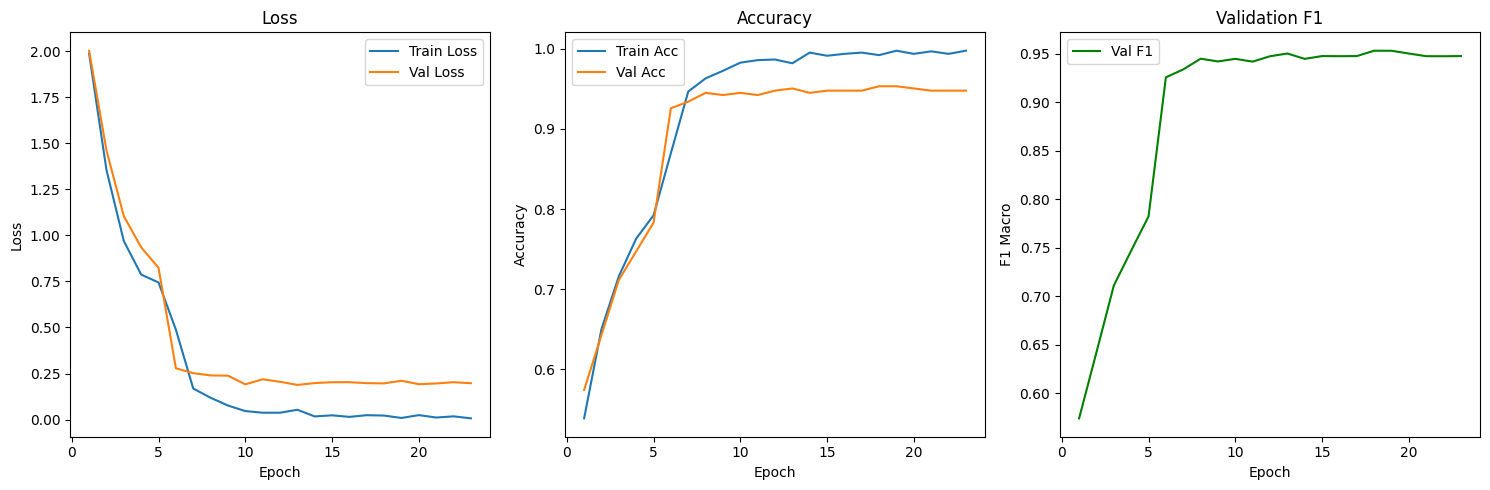

In [32]:
# Plotting curves
plot_training_curves(history)

# Evaluation on Test Set
Load the best model checkpoint and evaluate it on the held-out test set.


In [33]:
# Test evaluation
checkpoint = torch.load("checkpoint.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# using best model
test_metrics, y_true, y_pred = evaluate(model, test_loader, criterion=None, return_preds=True)

results = {
    "test_metrics": test_metrics,
    "classification_report": classification_report(
        y_true, y_pred, target_names=["daisy", "dandelion"], output_dict=True
    )
}

with open("test_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Test metrics:", test_metrics)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["daisy", "dandelion"]))

Test metrics: {'loss': None, 'accuracy': 0.945054945054945, 'f1_macro': 0.9439102564102564}

Classification Report:
               precision    recall  f1-score   support

       daisy       0.92      0.95      0.94        77
   dandelion       0.96      0.94      0.95       105

    accuracy                           0.95       182
   macro avg       0.94      0.95      0.94       182
weighted avg       0.95      0.95      0.95       182



# Confusion Matrix
Visualize the confusion matrix for the test predictions.


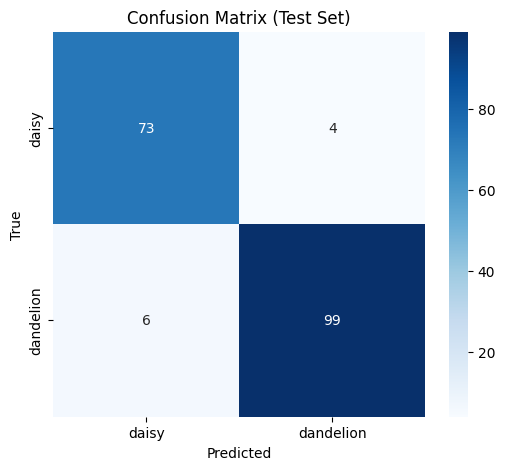

In [34]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["daisy", "dandelion"], yticklabels=["daisy", "dandelion"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()